<a href="https://colab.research.google.com/github/ZahraKiashemshaki/Rice_Image_Dataset---CNN/blob/main/CNN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer  # For handling missing values
import os  # For file handling
import scipy.stats as stats
import cv2  # For image processing
from PIL import Image  # Alternative to OpenCV for image handling
import matplotlib.pyplot as plt  # For plotting images and data distributions
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image augmentation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Rice_Image_Dataset.zip to Rice_Image_Dataset.zip


In [3]:
import zipfile

zip_path = "/content/Rice_Image_Dataset.zip"  # The path to the uploaded ZIP file
extract_path = "/content/rice_data/Rice_Image_Dataset"  # The directory where extracted the dataset

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")



Dataset extracted successfully!


In [4]:
# Check the extracted folder
print("Contents of content/rice_data/Rice_Image_Dataset", os.listdir("/content/rice_data/Rice_Image_Dataset"))

Contents of content/rice_data/Rice_Image_Dataset ['Rice_Image_Dataset']


In [5]:
nested_directory = "/content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset"
print(f"Contents of {nested_directory}:", os.listdir(nested_directory))

Contents of /content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset: ['Arborio', 'Jasmine', 'Basmati', 'S0168169921003021.pdf', 'Karacadag', 'Ipsala', 'Rice_Citation_Request.txt']


In [6]:
# Define the directory path
directory = "/content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset"

# List of files to remove
files_to_remove = ["S0168169921003021.pdf", "Rice_Citation_Request.txt"]

# Loop through the files and remove them
for file_name in files_to_remove:
    file_path = os.path.join(directory, file_name)  # Create the full file path
    if os.path.exists(file_path):  # Check if the file exists
        os.remove(file_path)  # Remove the file
        print(f"Removed: {file_path}")
    else:
        print(f"File not found: {file_path}")

# Verify the contents of the directory after removal
print("Updated contents of the directory:", os.listdir(directory))


Removed: /content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset/S0168169921003021.pdf
Removed: /content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset/Rice_Citation_Request.txt
Updated contents of the directory: ['Arborio', 'Jasmine', 'Basmati', 'Karacadag', 'Ipsala']


In [7]:
df_rice = directory  # Set the correct dataset path

# List all subdirectories (classes) in the data directory
classes = [cls for cls in os.listdir(df_rice) if os.path.isdir(os.path.join(df_rice, cls))]
print("Classes:", classes)


Classes: ['Arborio', 'Jasmine', 'Basmati', 'Karacadag', 'Ipsala']


In [8]:
img_size = (64, 64)  # Resize for efficiency
sum_pixels = np.zeros(3)  # For RGB mean
sum_squared = np.zeros(3)  # For variance
num_pixels = 0

In [9]:
# Count the number of images in each class
class_counts = {}
for cls in classes:
    class_dir = os.path.join(df_rice, cls)
    class_counts[cls] = len([img for img in os.listdir(class_dir) if not img.startswith('.')])  # Ignore hidden files

print("Class counts:", class_counts)


Class counts: {'Arborio': 15000, 'Jasmine': 15000, 'Basmati': 15000, 'Karacadag': 15000, 'Ipsala': 15000}


In [10]:
# Process images in batches
for cls in classes:
    class_folder = os.path.join(df_rice, cls)
    images = [img for img in os.listdir(class_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]

    for img in images:
        img_path = os.path.join(class_folder, img)

In [11]:
#Check for Missing Images in Each Class
missing_classes = []

for cls in classes:
    class_folder = os.path.join(df_rice, cls)
    images = os.listdir(class_folder)

    if len(images) == 0:
        missing_classes.append(cls)

if missing_classes:
    print("Classes with missing images:", missing_classes)
else:
    print("No missing images in any class.")

No missing images in any class.


In [12]:
#Check for Corrupted Images
corrupt_images = []

for cls in classes:
    class_folder = os.path.join(df_rice, cls)
    images = os.listdir(class_folder)

    for img in images:
        img_path = os.path.join(class_folder, img)

        # Try to read the image
        image = cv2.imread(img_path)
        if image is None:  # If image cannot be loaded, it might be corrupted
            corrupt_images.append(img_path)

if corrupt_images:
    print("Corrupted images found:", corrupt_images)
else:
    print("No corrupted images found.")

No corrupted images found.


In [13]:
#Check for Non-Image Files

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

non_image_files = []

for cls in classes:
    class_folder = os.path.join(df_rice, cls)
    images = os.listdir(class_folder)

    for img in images:
        if not img.lower().endswith(valid_extensions):
            non_image_files.append(os.path.join(class_folder, img))

if non_image_files:
    print("Non-image files found:", non_image_files)
else:
    print("No non-image files found.")

No non-image files found.


In [14]:
# Count images per class
class_counts = {}
image_paths = []

for cls in classes:
    class_folder = os.path.join(df_rice, cls)
    images = os.listdir(class_folder)
    class_counts[cls] = len(images)

    # Collect image paths for visualization
    for img in images[:5]:  # Only a few images per class for sample visualization
        image_paths.append(os.path.join(class_folder, img))

# Print class distribution
print("Class Distribution:", class_counts)

Class Distribution: {'Arborio': 15000, 'Jasmine': 15000, 'Basmati': 15000, 'Karacadag': 15000, 'Ipsala': 15000}


In [15]:
from PIL import Image

# List class folders, ignoring files like .DS_Store in Mac
classes = [cls for cls in os.listdir(df_rice) if os.path.isdir(os.path.join(df_rice, cls))]

# Process images in batches
for cls in classes:
    class_folder = os.path.join(df_rice, cls)
    images = [img for img in os.listdir(class_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]

    for img in images:
        img_path = os.path.join(class_folder, img)

        # Open image and convert to RGB
        image = Image.open(img_path).convert("RGB")
        image = image.resize(img_size)  # Resize for consistency
        image_np = np.array(image) / 255.0  # Normalize to [0,1]

        # Compute sum and sum of squares
        sum_pixels += image_np.mean(axis=(0, 1))  # Mean per channel
        sum_squared += (image_np ** 2).mean(axis=(0, 1))  # Squared mean per channel
        num_pixels += 1

# Compute final mean and std
mean_pixel_value = sum_pixels / num_pixels
std_pixel_value = np.sqrt(sum_squared / num_pixels - mean_pixel_value ** 2)

print(f"Mean Pixel Value: {mean_pixel_value}")
print(f"Standard Deviation: {std_pixel_value}")

Mean Pixel Value: [0.11813352 0.1191349  0.12313968]
Standard Deviation: [0.29148537 0.29402779 0.30322721]


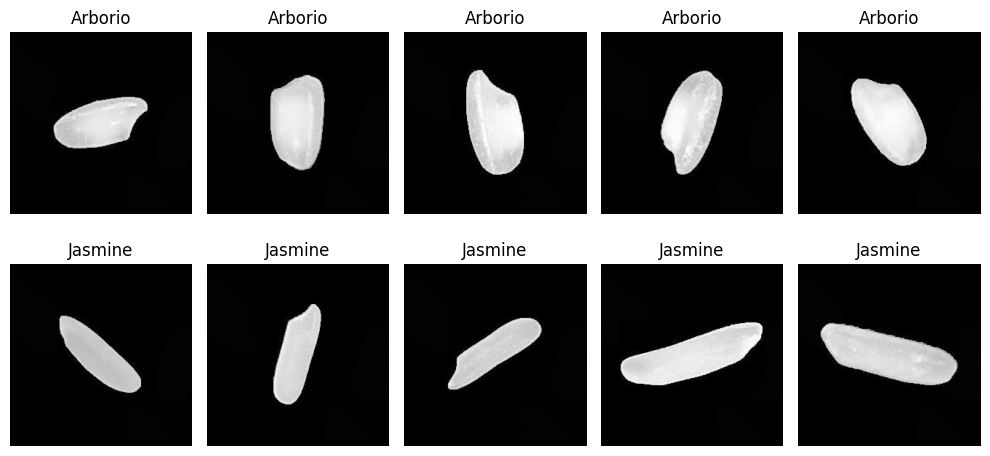

In [16]:
#Visualize Sample Images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i, img_path in enumerate(image_paths[:10]):  # Show first 10 images
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(img_path.split('/')[-2])  # Show class name

plt.tight_layout()
plt.show()

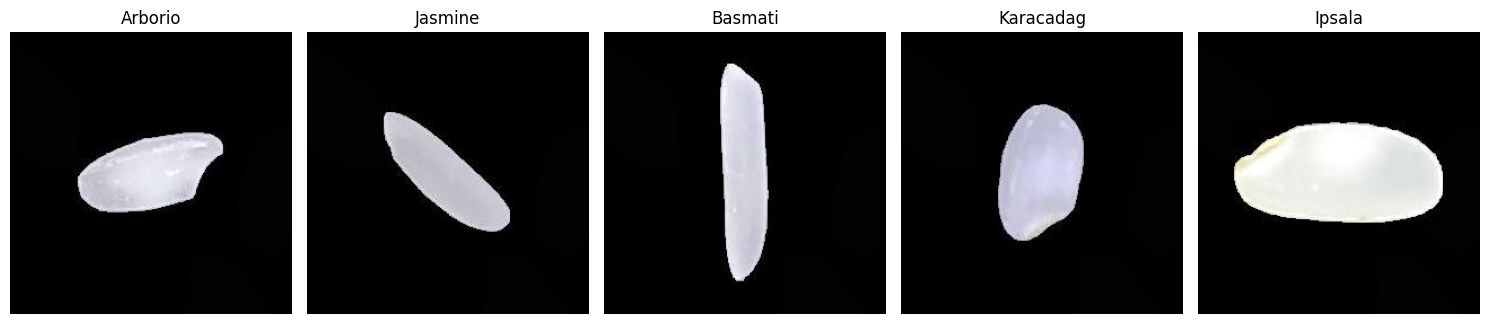

In [17]:
# Display sample images

fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns for 5 samples
for i, cls in enumerate(classes):
    class_dir = os.path.join(df_rice, cls)
    img_names = [img for img in os.listdir(class_dir) if not img.startswith('.')]  # Ignore hidden files
    img_name = img_names[0]  # Take the first image from each class
    img_path = os.path.join(class_dir, img_name)
    img = Image.open(img_path)

    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

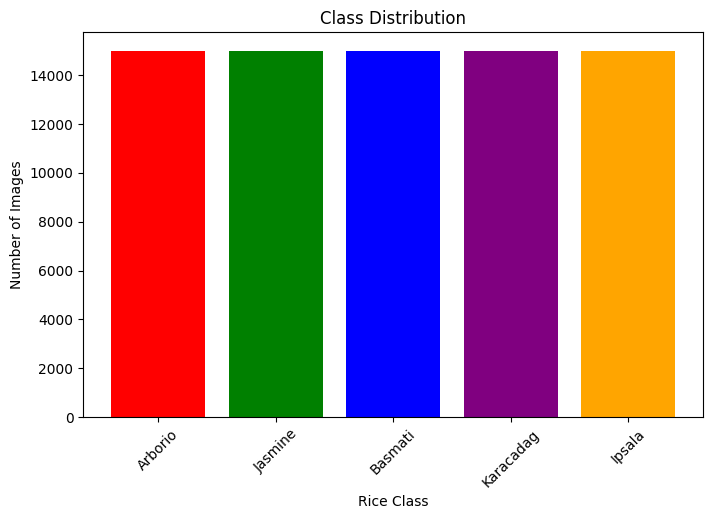

In [18]:
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['red', 'green', 'blue', 'purple', 'orange'])
plt.xlabel("Rice Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

In [19]:
import shutil

# Create a new directory named 'df_rice'
os.makedirs("df_rice", exist_ok=True)

# Copy the dataset to the new directory
source_dir = "/content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset"
destination_dir = "df_rice"
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

# Verify the contents of the new directory
print("Contents of df_rice:", os.listdir("df_rice"))

Contents of df_rice: ['Arborio', 'Jasmine', 'Basmati', 'Karacadag', 'Ipsala']


Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Class indices: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


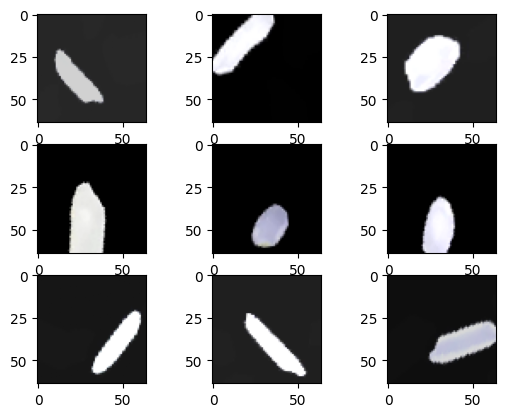

In [20]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Define image size and batch size
IMAGE_SIZE = (64, 64)  # Reduced image size for faster processing
BATCH_SIZE = 32

# Data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,  # Increase rotation range if needed
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flip
    brightness_range=(0.8, 1.2),  # Adjust brightness
    channel_shift_range=50.0,  # Adjust channel shifts
    fill_mode='nearest'
)

# Create data generators
train_generator = datagen.flow_from_directory(
    df_rice,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Use 80% of data for training
)

val_generator = datagen.flow_from_directory(
    df_rice,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Use 20% of data for validation
)

# Print class indices
print("Class indices:", train_generator.class_indices)

# Visualize augmented images
for X_batch, y_batch in train_generator:
    for i in range(0, 9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i])
    plt.show()
    break

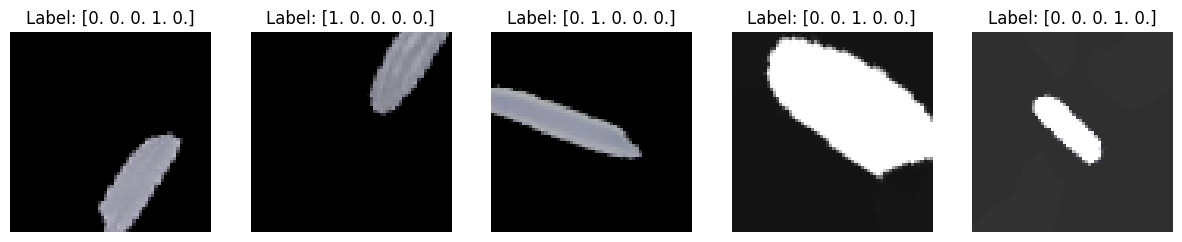

In [21]:
# Visualize augmented images
def plot_augmented_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

plot_augmented_images(train_generator)

In [22]:
# Count samples per class in the training set
class_counts = np.sum(train_generator.labels, axis=0)
print("Class counts:", class_counts)

Class counts: 120000


In [23]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define num_classes based on the number of classes in the dataset
num_classes = len(train_generator.class_indices)

# Define a simpler model with additional regularization
model = tf.keras.Sequential([
    # First convolutional block
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Global average pooling instead of flatten
    layers.GlobalAveragePooling2D(),

    # Fully connected layer with dropout for regularization
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,501 (25.39 KB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 96 (384.00 B)

In [25]:
# Training the Model
# When training the model, use the early_stopping callback to prevent overfitting:

history = model.fit(
    train_generator,
    epochs=10,  # Use a higher number of epochs with early stopping
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 435s 232ms/step - accuracy: 0.8914 - loss: 0.3970 - val_accuracy: 0.8013 - val_loss: 0.6923
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 401s 214ms/step - accuracy: 0.8932 - loss: 0.3845 - val_accuracy: 0.9171 - val_loss: 0.3012
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 401s 214ms/step - accuracy: 0.8941 - loss: 0.3907 - val_accuracy: 0.8767 - val_loss: 0.4154
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 401s 214ms/step - accuracy: 0.8902 - loss: 0.3910 - val_accuracy: 0.8256 - val_loss: 0.5774
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 400s 214ms/step - accuracy: 0.8907 - loss: 0.3907 - val_accuracy: 0.4680 - val_loss: 3.0199
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 433s 231ms/step - accuracy: 0.8969 - loss: 0.3716 - val_accuracy: 0.7911 - val_loss: 0.6463
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 403s 215ms/step - accuracy: 0.8924 - loss: 0.3845 - val_accuracy: 0.9147 - val_loss: 0.3064


In [26]:
model.save("rice_cnn_model.keras")  # Save model in the native Keras format

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale, no augmentation

test_generator = test_datagen.flow_from_directory(
    "df_rice",  # Change this to your test dataset folder
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data
)

Found 75000 images belonging to 5 classes.


In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 133s 57ms/step - accuracy: 0.9639 - loss: 0.1908
Test Accuracy: 94.35%


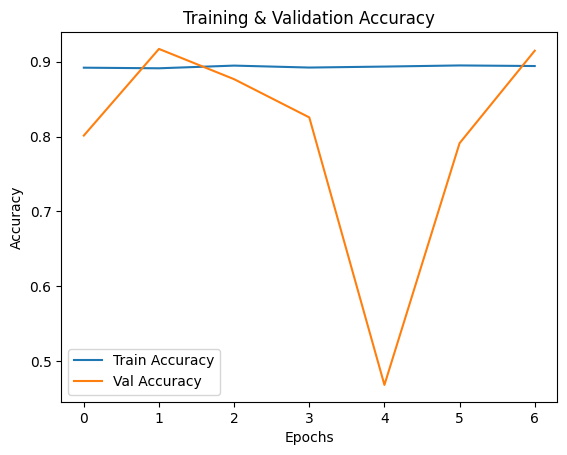

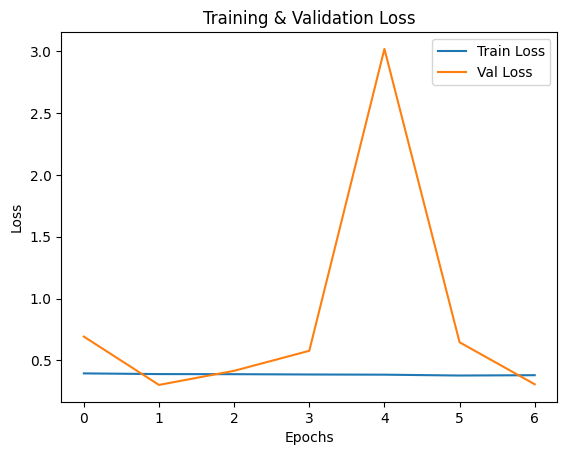

In [29]:
# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

# Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


In [30]:
import glob

# Search for images inside a specific folder
image_files = glob.glob("/content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset/Basmati/*.jpg")

# Print the first found image
if image_files:
    print("Example Image Path:", image_files[0])
else:
    print("No images found in this directory.")


Example Image Path: /content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset/Basmati/basmati (11218).jpg


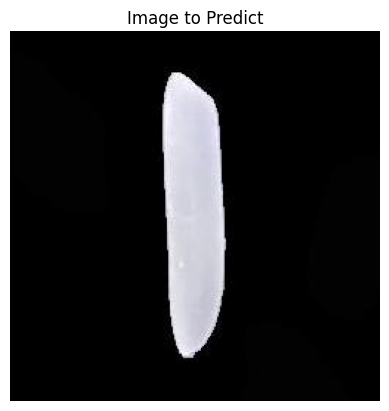

Trying to load image from: /content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset/Basmati/basmati (11218).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Predicted Class: Basmati


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to predict an image
def predict_image(img_path, model):
    print(f"Trying to load image from: {img_path}")

    # Load the image from the given file path
    img = cv2.imread(img_path)

    # Check if the image is loaded correctly
    if img is None:
        print(f"Error loading image: {img_path}. Please check the file path.")
        return

    # Resize image to match the model input (64x64)
    img = cv2.resize(img, (64, 64))

    # Convert BGR (OpenCV default) to RGB (expected by Keras models)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize the image (scale pixel values between 0 and 1)
    img = img / 255.0

    # Expand dimensions to match the model input shape (1, 64, 64, 3)
    img = np.expand_dims(img, axis=0)

    # Make prediction
    predictions = model.predict(img)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get class labels from the training generator
    class_labels = {v: k for k, v in train_generator.class_indices.items()}

    # Print the predicted class label
    print(f"Predicted Class: {class_labels[predicted_class]}")

# Use the found image path
img_path = "/content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset/Basmati/basmati (11218).jpg"

# Display the image
img = cv2.imread(img_path)
if img is None:
    print(f"Error loading image: {img_path}. Please check the file path.")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Image to Predict")
    plt.axis("off")
    plt.show()

# Predict the image
predict_image(img_path, model)

In [36]:
print(f"Trying to load image from: {img_path}")
img = cv2.imread(img_path)


Trying to load image from: /content/rice_data/Rice_Image_Dataset/Rice_Image_Dataset/Basmati/basmati (11218).jpg


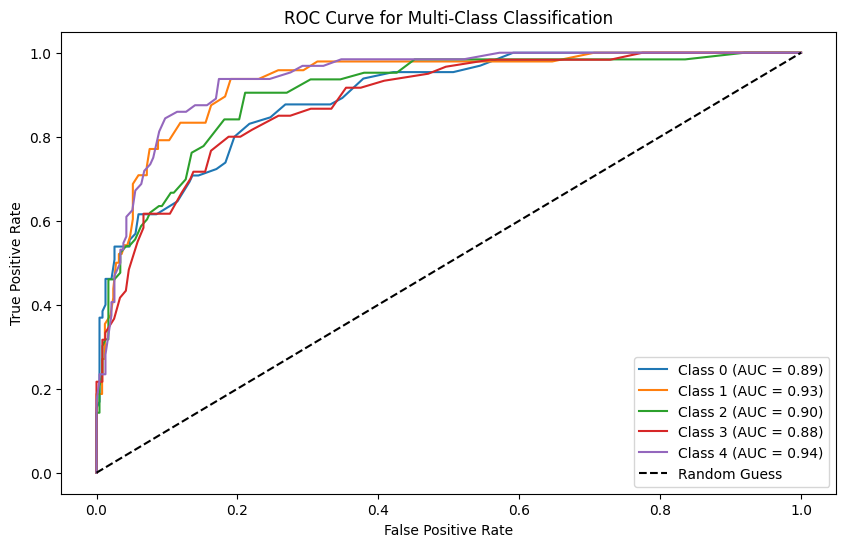

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Example: Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_classes=5, n_informative=10, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a model (example: RandomForestClassifier)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)  # Predicted class labels
y_pred_proba = model.predict_proba(X_test)  # Predicted probabilities for each class

# Binarize the labels
classes = np.unique(y_test)
y_true_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for cls in classes:
    plt.plot(fpr[cls], tpr[cls], label=f'Class {cls} (AUC = {roc_auc[cls]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()